<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/0403%20AB%20Test/Session%20HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question: AB testing 환경 구현하기

- 분석 목표: 과연 B group의 campaign은 더 효과적일까?

- 적절한 전처리 후, A/B Test를 수행하고, 그에 따른 결과가 Bootstraping에서도 보존되는지를 확인하라.

- 특별한 성능 목표는 없다.

#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
!pip install sidetable
import sidetable as stb
!pip install graphviz
import statsmodels.formula.api as smf
import graphviz as gr
from sklearn.linear_model import LogisticRegression
from scipy.stats import t

#About Dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/BADA/0403 A B 테스트, 가설검정, 실험 설계/KAG_conversion_data.csv')
df

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710001,8,2


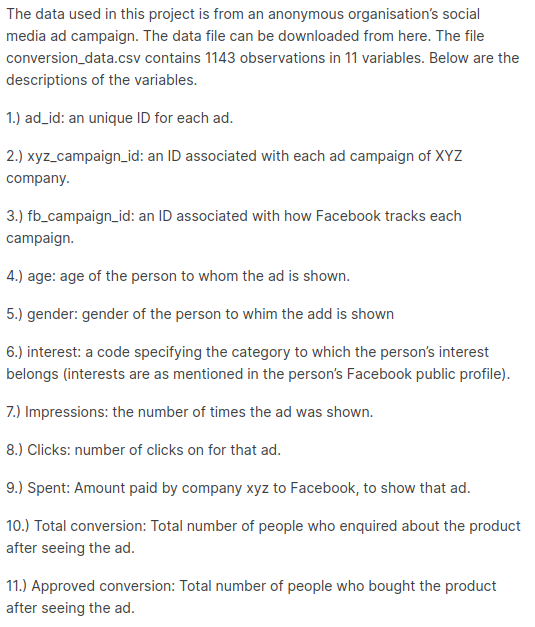

# Freq check & manipulation

In [4]:
df.stb.freq(['xyz_campaign_id'])

,xyz_campaign_id,count,percent,cumulative_count,cumulative_percent
0,1178,625,54.680665,625,54.680665
1,936,464,40.594926,1089,95.275591
2,916,54,4.724409,1143,100.000000


In [5]:
#drop 'campaign_id' 916
df = df[df['xyz_campaign_id'] != 916]
#drop 'fb_campaign_id'
df = df.drop('fb_campaign_id', axis = 1)

In [6]:
df.stb.freq(['xyz_campaign_id'])

,xyz_campaign_id,count,percent,cumulative_count,cumulative_percent
0,1178,625,57.392103,625,57.392103
1,936,464,42.607897,1089,100.000000


- A 그룹: id 1178
- B 그룹: id 936

In [8]:
df['xyz_campaign_id'] = df['xyz_campaign_id'].replace({1178: 0, 936: 1})
df['gender'] = df['gender'].replace({'M': 0, 'F': 1})
df['age'] = df['age'].replace({'30-34': 30, '35-39': 35, '40-44': 40, '45-49': 45})

#Data Visualization

##Histogram

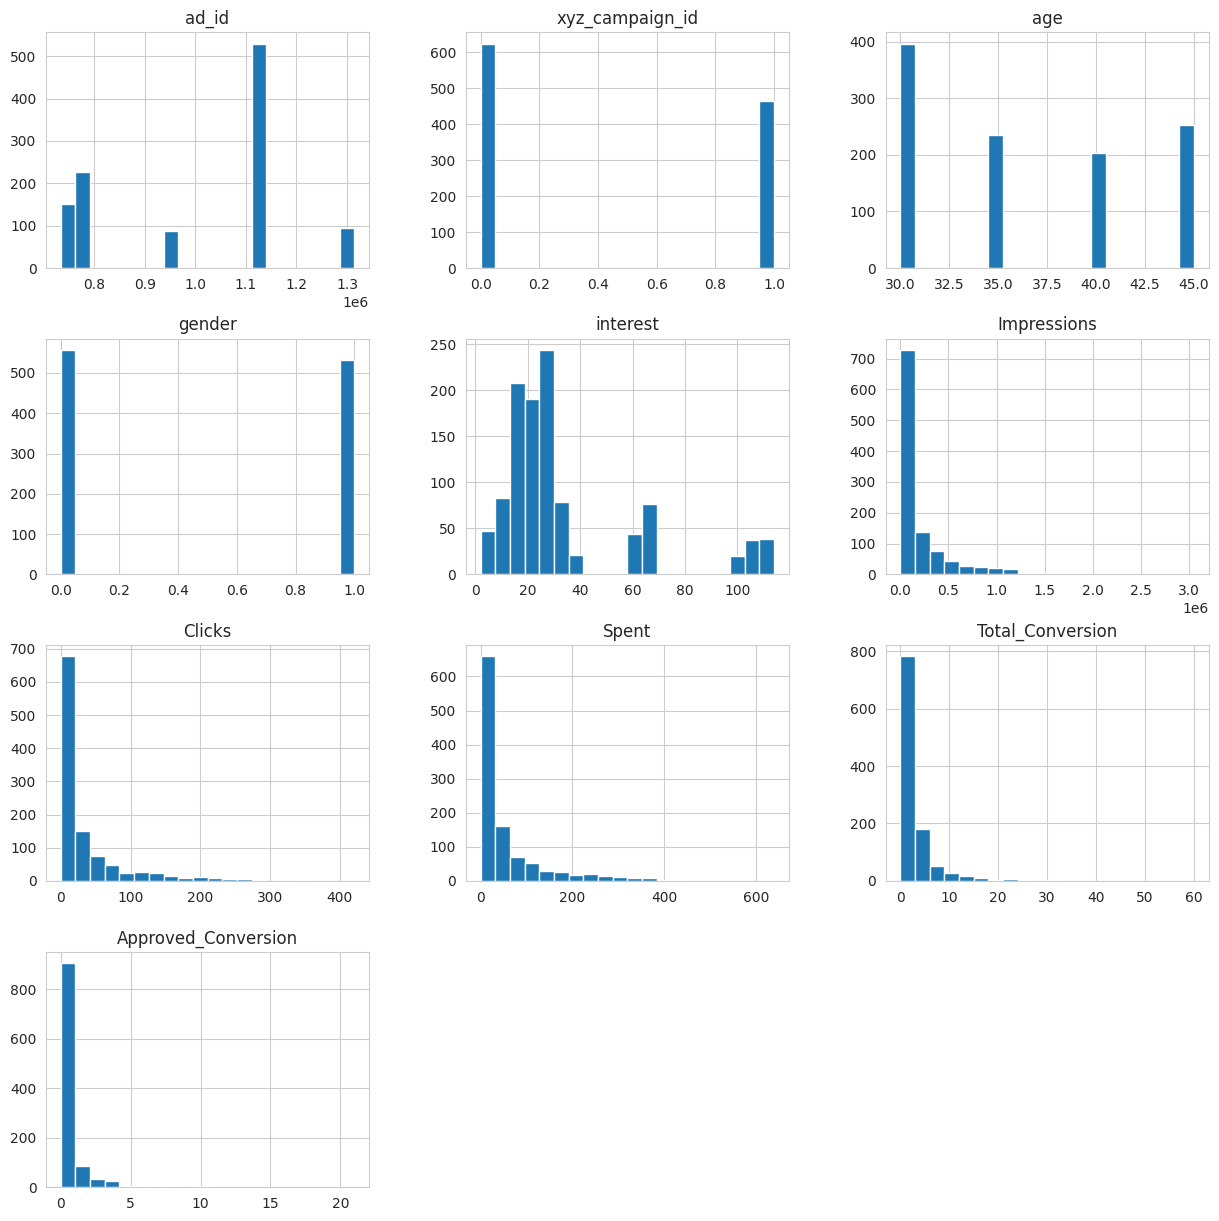

In [11]:
axList = df.hist(bins = 20, figsize = (15, 15))

## violin plot

In [12]:
def plot_distributions(df, X, d):  #X: list of column names / d: target variable
    df_long = df.copy()[X + [d]]
    df_long[X] = (df_long[X] - df_long[X].mean()) / df_long[X].std()  #standardized X
    df_long = pd.melt(df_long, id_vars = d, value_name = 'value')  #d를 기준으로. 나머지를 행으로
    sns.violinplot(y = 'variable', x= 'value', hue = d, data = df_long, split= True).set(xlabel = '', ylabel = '', title = 'Normalized Value Distribution')

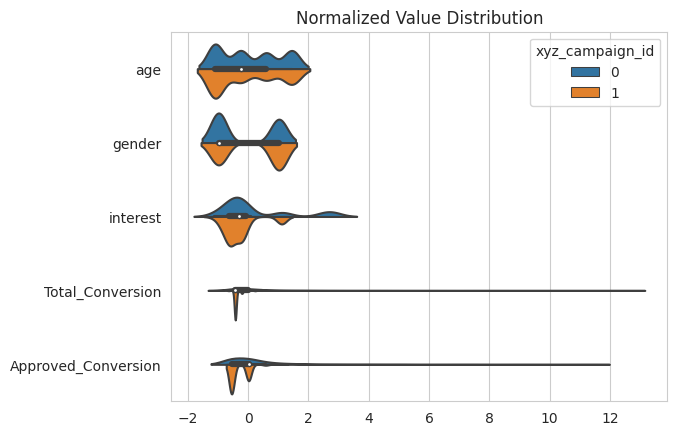

In [14]:
plot_distributions(df, ['age', 'gender', 'interest', 'Total_Conversion', 'Approved_Conversion'], 'xyz_campaign_id')

## Correlation Plot (Heatmap)

In [15]:
corr = df.corr(); corr

,ad_id,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
ad_id,1.000000,-0.924047,0.068200,-0.083195,0.455533,0.448785,0.417709,0.418271,0.337187,0.265778
xyz_campaign_id,-0.924047,1.000000,-0.071528,0.108943,-0.259918,-0.482842,-0.457006,-0.463833,-0.336634,-0.279229
age,0.068200,-0.071528,1.000000,0.056082,0.040345,0.093680,0.202753,0.185779,-0.075729,-0.091337
gender,-0.083195,0.108943,0.056082,1.000000,0.037851,0.061491,0.166388,0.121229,0.023219,-0.029426
interest,0.455533,-0.259918,0.040345,0.037851,1.000000,0.092277,0.078970,0.060024,0.114006,0.054179
Impressions,0.448785,-0.482842,0.093680,0.061491,0.092277,1.000000,0.947717,0.969919,0.811402,0.684350
Clicks,0.417709,-0.457006,0.202753,0.166388,0.078970,0.947717,1.000000,0.992799,0.691796,0.558071
Spent,0.418271,-0.463833,0.185779,0.121229,0.060024,0.969919,0.992799,1.000000,0.722897,0.592135
Total_Conversion,0.337187,-0.336634,-0.075729,0.023219,0.114006,0.811402,0.691796,0.722897,1.000000,0.865133
Approved_Conversion,0.265778,-0.279229,-0.091337,-0.029426,0.054179,0.684350,0.558071,0.592135,0.865133,1.000000


<Axes: >

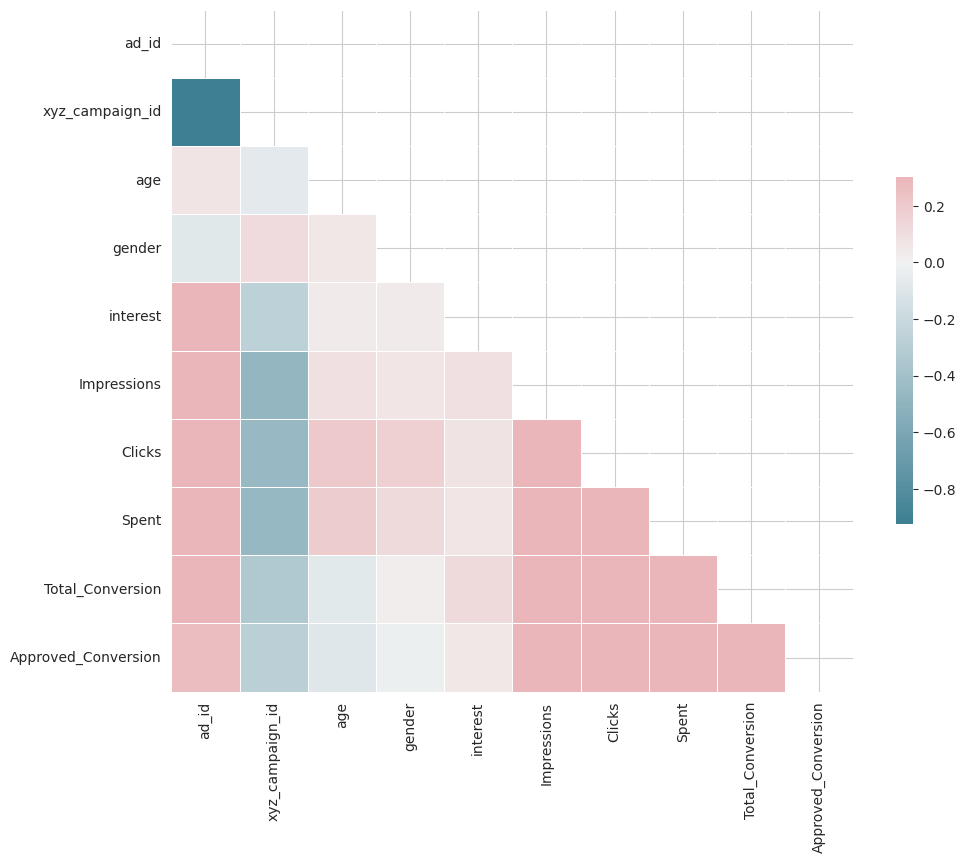

In [16]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True  #np.triu_indices_from: 2차원 테이블에서 위쪽 삼각형

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, linewidths = .5, cbar_kws = {'shrink': .5})

#Add New Variables

In [17]:
#CTR: Click Through Rate. 클릭률. 광고가 노출이 된 횟수 대비 광고가 클릭된 횟수의 비율. 사용자들이 광고에 어떻게 반응하고 있는지 알 수 있음.
df['CTR'] = df['Clicks'] / df['Impressions'] * 100

#CVR: ConVersion Rate. 광고 클릭 대비 전환율. 구매 전환율.
df['CVR'] = df['Approved_Conversion'] / df['Clicks'] * 100

#CPC: Cost Per Click. 클릭당 비용.
df['CPC'] = df['Spent'] / df['Clicks']

#CPM: Cost Per Mile. 광고가 1000번 노출됐을 때의 비용.
df['CPM'] = df['Spent'] / (df['Impressions'] / 1000)

df = df.replace([np.inf, -np.inf, np.nan], 0)

df.head()

,ad_id,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CVR,CPC,CPM
54,734209,1,30,0,10,1772,0,0.00,1,1,0.000000,0.0,0.0000,0.000000
55,734210,1,30,0,10,13329,4,5.63,1,1,0.030010,25.0,1.4075,0.422387
56,734215,1,30,0,15,13659,3,3.84,1,0,0.021964,0.0,1.2800,0.281133
57,734243,1,30,0,21,739,0,0.00,1,1,0.000000,0.0,0.0000,0.000000
58,734266,1,30,0,25,605,0,0.00,1,0,0.000000,0.0,0.0000,0.000000


In [19]:
#새로운 변수를 만들 때 사용한 기존의 변수들은 제거하자
df = df.drop(['Clicks', 'Spent', 'Total_Conversion', 'Approved_Conversion', 'Impressions'], axis = 1)
df.head()

,ad_id,xyz_campaign_id,age,gender,interest,CTR,CVR,CPC,CPM
54,734209,1,30,0,10,0.000000,0.0,0.0000,0.000000
55,734210,1,30,0,10,0.030010,25.0,1.4075,0.422387
56,734215,1,30,0,15,0.021964,0.0,1.2800,0.281133
57,734243,1,30,0,21,0.000000,0.0,0.0000,0.000000
58,734266,1,30,0,25,0.000000,0.0,0.0000,0.000000


# Outlier Detection

In [18]:
df.describe()

,ad_id,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CVR,CPC,CPM
count,1.089000e+03,1089.000000,1089.000000,1089.000000,1089.000000,1.089000e+03,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,1.001015e+06,0.426079,36.427916,0.488522,33.301194,1.955481e+05,34.942149,53.769991,2.943985,0.968779,0.016341,8.544747,1.245938,0.239317
std,1.883963e+05,0.494733,5.910219,0.500098,27.373828,3.178397e+05,57.843979,88.341333,4.575107,1.773202,0.011252,22.079976,0.606785,0.157475
min,7.342090e+05,0.000000,30.000000,0.000000,2.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.788080e+05,0.000000,30.000000,0.000000,16.000000,7.589000e+03,1.000000,1.560000,1.000000,0.000000,0.010235,0.000000,1.278947,0.153195
50%,1.121251e+06,0.000000,35.000000,0.000000,25.000000,6.378500e+04,10.000000,14.630000,1.000000,1.000000,0.015842,0.000000,1.456626,0.248816
75%,1.121828e+06,1.000000,40.000000,1.000000,31.000000,2.376030e+05,40.000000,62.870000,3.000000,1.000000,0.022907,4.494382,1.606053,0.331575
max,1.314415e+06,1.000000,45.000000,1.000000,114.000000,3.052003e+06,421.000000,639.949998,60.000000,21.000000,0.105932,200.000000,2.212000,1.504237


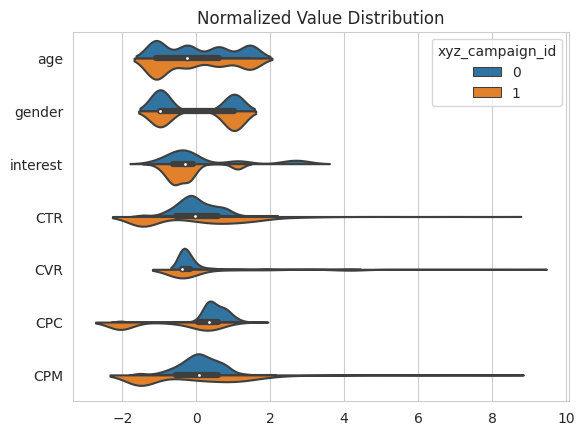

In [20]:
plot_distributions(df, ['age', 'gender', 'interest', 'CTR', 'CVR', 'CPC', 'CPM'], 'xyz_campaign_id')

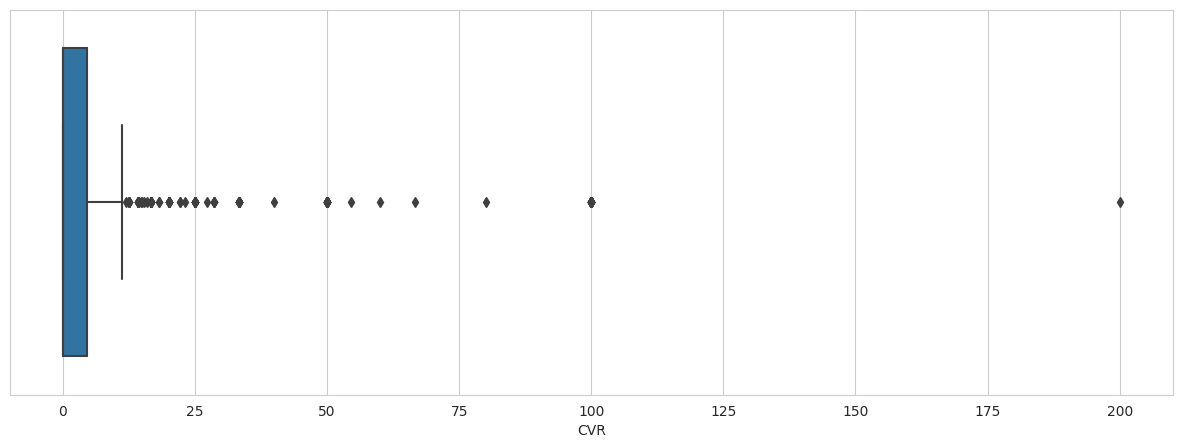

In [22]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(data = df, x = 'CVR')

CVR이 200인 outlier가 존재한다. 추후 분석 시, 해당 데이터를 제거할 것이다.

#Choose Target Variable for A/B Test

In [25]:
smf.ols('CTR ~ xyz_campaign_id', data = df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0162,0.000,36.026,0.000,0.015,0.017
xyz_campaign_id,0.0003,0.001,0.406,0.684,-0.001,0.002


pvalue가 0.05보다 커 유의하지 않다. 즉, A/B Test의 target variable로 적합하지 않다.

In [24]:
smf.ols('CVR ~ xyz_campaign_id', data = df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1146,0.869,5.885,0.000,3.409,6.820
xyz_campaign_id,8.0504,1.331,6.046,0.000,5.438,10.663


In [26]:
smf.ols('CPC ~ xyz_campaign_id', data = df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.5423,0.020,77.115,0.000,1.503,1.582
xyz_campaign_id,-0.6956,0.031,-22.701,0.000,-0.756,-0.635


In [27]:
smf.ols('CPM ~ xyz_campaign_id', data = df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2506,0.006,39.896,0.000,0.238,0.263
xyz_campaign_id,-0.0264,0.010,-2.742,0.006,-0.045,-0.008


CVR, CPC, CPM 모두 pvalue가 0.05보다 작아 유의하나, CVR의 선형 회귀에서 회귀계수가 가장 크게 나타난다.(캠페인 id가 1일 때 id가 0인 경우에 비해 CVR이 8.0504만큼 더 크다.)

=> 따라서 A/B Test의 Target Variable로 CVR을 사용할 것이다.

# AB test & Treatment Effect Estimation

In [30]:
T = 'xyz_campaign_id'
Y = 'CVR'
X = df.columns.drop(['ad_id', 'CTR', 'CPC', 'CPM', T, Y])

ps_model = LogisticRegression(C = 1e6).fit(df[X], df[T])
#C: 정규화의 강도를 조절. 값이 클수록 정규화의 강도가 낮아짐. -> 모델은 학습 데이터에 더욱 적합해 오차를 최소화하려고 노력함 -> 과적합 위험

In [31]:
#CVR의 outlier 제거
df2 = df.drop(df[df['CVR'] > 100].index, inplace=False)

In [35]:
def get_obbs_diff(df):
    #propensity score: X의 각 행에 대해, xyz_campaign_id가 1일 확률
    data_ps = df.assign(propensity_score = ps_model.predict_proba(df[X])[:, 1])

    #처리 그룹에 대한 가중치를 계산
    weight_t = 1 / data_ps.query('xyz_campaign_id == 1')['propensity_score']
    #대조 그룹에 대한 가중치를 계산
    weight_nt = 1 / (1 - data_ps.query('xyz_campaign_id == 0')['propensity_score'])
    weight_t = weight_t.to_frame()
    weight_nt = weight_nt.to_frame()

    #각 행의 가중치를 계산
    weight = ((data_ps['xyz_campaign_id'] - data_ps['propensity_score']) / (data_ps['propensity_score'] * (1 - data_ps['propensity_score'])))

    #ate: average treatment effect. 처리 그룹과 대조 그룹 간의 평균 차이
    ate = np.mean(weight * data_ps['CVR'])

    #대조 그룹 내에서 평균값을 계산
    y0 = (data_ps.query('xyz_campaign_id == 0')['CVR'] * weight_nt['propensity_score']).sum() / len(data_ps)

    #처리 그룹 내에서 평균값을 계산
    y1 = (data_ps.query('xyz_campaign_id == 1')['CVR'] * weight_t['propensity_score']).sum() / len(data_ps)

    return ate, y0, y1

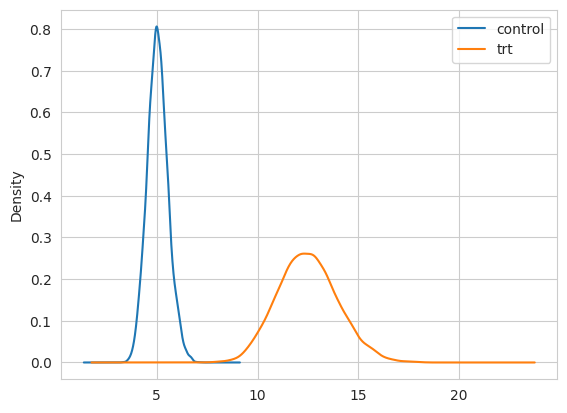

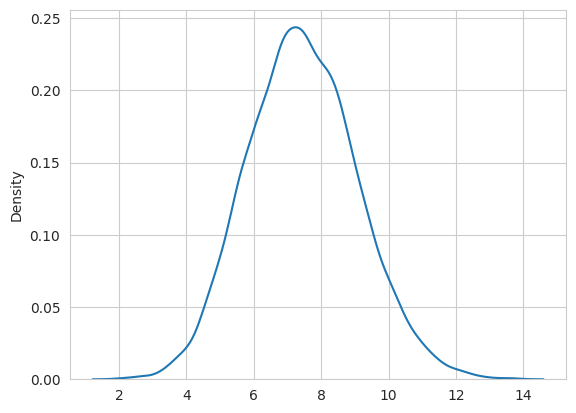

In [37]:
#부트스트랩 샘플링
boot_mean = []
boot_mean_0 = []
boot_mean_1 = []

for i in range(10000):
    boot_sample = df2.sample(frac = 1, replace = True)  #frac=1: 모든 데이터를 반환, replace=True: 복원 추출
    boot_diff, boot_mean_0_tmp, boot_mean_1_tmp = get_obbs_diff(boot_sample)
    boot_mean.append(boot_diff)
    boot_mean_0.append(boot_mean_0_tmp)
    boot_mean_1.append(boot_mean_1_tmp)

boot_gr = pd.DataFrame({'control': boot_mean_0, 'trt': boot_mean_1})
boot_gr.plot(kind = 'kde')
plt.show()

ax = sns.kdeplot(np.array(boot_mean))

- 대조 그룹의 평균값이 5 주위에서 가장 많이 분포하고 있다.
- 처리 그룹의 평균값이 12 주위에서 가장 많이 분포하고 있다.
- ATE가 7 주위에서 가장 많이 분포하고 있다.

⭐ A/B Test 결과, 대조 그룹에 비해 처리 그룹의 "광고 클릭 대비 구매 전환율"이 더욱 높음을 알 수 있다. 따라서 campaign ID 936이 더욱 효과적이다.

In [40]:
#ATE 95% 신뢰구간

#표본 크기
n = len(boot_mean)
#자유도
dof = n - 1

boot_mean_mean = np.mean(boot_mean)
boot_mean_std = np.std(boot_mean, ddof = 1)  #ddof=1: 비편향 표준편차 계산
#표준오차
std_err = boot_mean_std / (n ** 0.5)

CI = t.interval(.95, dof, loc = boot_mean_mean, scale = std_err)
print('95% CI:', CI)

95% CI: (7.4136604417184175, 7.47718866181133)
